In [1]:
import xarray as xr
import torch
from xbatcher import BatchGenerator
import matplotlib.pyplot as plt
from utils.general import load_config
import pandas as pd

config = load_config()

## Generate Animation at Netflix speed

In [2]:
data = xr.open_dataset(
    config["dataset"]["hr_zarr_url"],
    engine="zarr", storage_options={"client_kwargs": {"trust_env": "true"}},
    chunks={})
start_date = "2025-03-01"
end_date = "2025-03-01"
latitude_range = tuple(config["dataset"]["latitude_range"])
longitude_range = tuple(config["dataset"]["longitude_range"])
hr_data = data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                longitude=slice(longitude_range[0],longitude_range[1]),
                time=slice(start_date, end_date))

data_vars = list(hr_data.data_vars)

hr_data

<xarray.Dataset> Size: 4GB
Dimensions:           (time: 24, latitude: 819, longitude: 1479)
Coordinates:
    entireAtmosphere  float64 8B ...
  * latitude          (latitude) float64 7kB 35.01 35.05 35.1 ... 70.92 70.97
  * longitude         (longitude) float64 12kB -24.96 -24.92 ... 39.95 39.99
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 192B 2025-03-01 ... 2025-03-01T23...
Data variables: (12/34)
    blh               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    chnk              (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    d2m               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    e                 (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    ewss              (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    hcc               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    ...                ...
    tp                (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    tprate            (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    tsr               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    ttr               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    u10               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
    v10               (time, latitude, longitude) float32 116MB dask.array<chunksize=(24, 228, 56), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-11-14T08:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [3]:
import os
import yaml
from IPython.display import HTML
from loguru import logger
from matplotlib.animation import FuncAnimation
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import re

In [4]:
def find_coord_name(coord_names, pattern):
    """
    Function to find coordinate names using regex.
    """
    for name in coord_names:
        if pattern.search(name):
            return name
    return None


class Visualizer:

    @staticmethod
    def get_metadata(data):
        """
        Extract relevant metadata (title, unit, colorbar label) from dataset attributes.
        """
        long_name = data.attrs.get("long_name", "Unknown Variable")
        standard_name = data.attrs.get("standard_name", long_name)
        units = data.attrs.get("units", "")
        title = f"{long_name} ({units})" if units else long_name
        colorbar_label = f"{standard_name} [{units}]" if units else standard_name
        return title, colorbar_label

    @staticmethod
    def generate_animation(data, cmap="YlOrRd", show_coastlines=True, fps=30):
        """
        Generate an animation with a customizable FPS.

        Parameters:
        - data: xarray DataArray to animate
        - cmap: Colormap for visualization (default: 'YlOrRd')
        - show_coastlines: Show/hide coastlines (default: True)
        - fps: Frames per second for the animation (default: 30)
        """
        lat_pattern = re.compile(r'lat(itude)?', re.IGNORECASE)
        lon_pattern = re.compile(r'lon(gitude)?', re.IGNORECASE)
        coord_names = data.coords.keys()

        lat_name = find_coord_name(coord_names, lat_pattern)
        lon_name = find_coord_name(coord_names, lon_pattern)

        if lat_name is None or lon_name is None:
            raise ValueError("Latitude and/or Longitude coordinates not found.")

        title, colorbar_label = Visualizer.get_metadata(data)

        fig = plt.figure(figsize=(19.2, 10.8), dpi=100)  # Keep consistent 1080p resolution
        ax = plt.axes(projection=ccrs.PlateCarree())

        if show_coastlines:
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax.add_feature(cfeature.LAND)

        heatmap = ax.pcolormesh(data[lon_name], data[lat_name], data.isel(time=0),
                                cmap=cmap, transform=ccrs.PlateCarree())

        # Set axis limits to match data
        ax.set_xlim([data[lon_name].min(), data[lon_name].max()])
        ax.set_ylim([data[lat_name].min(), data[lat_name].max()])

        # Align colorbar width with heatmap
        pos = ax.get_position()
        cbar_ax = fig.add_axes([pos.x0, pos.y0 - 0.05, pos.width, 0.02])
        cbar = fig.colorbar(heatmap, cax=cbar_ax, orientation='horizontal')
        cbar.set_label(colorbar_label)
        ax.set_title(title)

        mesh = ax.pcolormesh(data[lon_name], data[lat_name], data.isel(time=0),
                             cmap=cmap, transform=ccrs.PlateCarree())

        def update(frame):
            time_str = np.datetime_as_string(data.time[frame].values, unit='h')
            mesh.set_array(data.isel(time=frame).values.flatten())
            ax.set_title(f"{title} - {time_str}")
            return mesh,

        interval = 1000 / fps  # Convert FPS to milliseconds
        animation = FuncAnimation(fig, update, frames=len(data.time), interval=interval, blit=True)

        plt.close()
        return animation, HTML(animation.to_html5_video())

In [5]:
# animation, video = Visualizer.generate_animation(hr_data['t2m'].load(), cmap="plasma_r", show_coastlines=True, fps=30)

In [8]:
data = xr.open_dataset(
    config["dataset"]["hr_zarr_url"],
    engine="zarr", storage_options={"client_kwargs": {"trust_env": "true"}},
    chunks={})
start_date = "2025-03-01"
end_date = "2025-03-01"
latitude_range = tuple(config["dataset"]["latitude_range"])
longitude_range = tuple(config["dataset"]["longitude_range"])
hr_data = data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                longitude=slice(longitude_range[0],longitude_range[1]),
                time=slice(start_date, end_date))

data_vars = list(hr_data.data_vars)
hr_data = hr_data[["t2m", "u10", "v10"]].load()
hr_data = hr_data.load()

In [9]:
def calculate_wind_speed(u10, v10):

    return np.sqrt(u10**2 + v10**2)

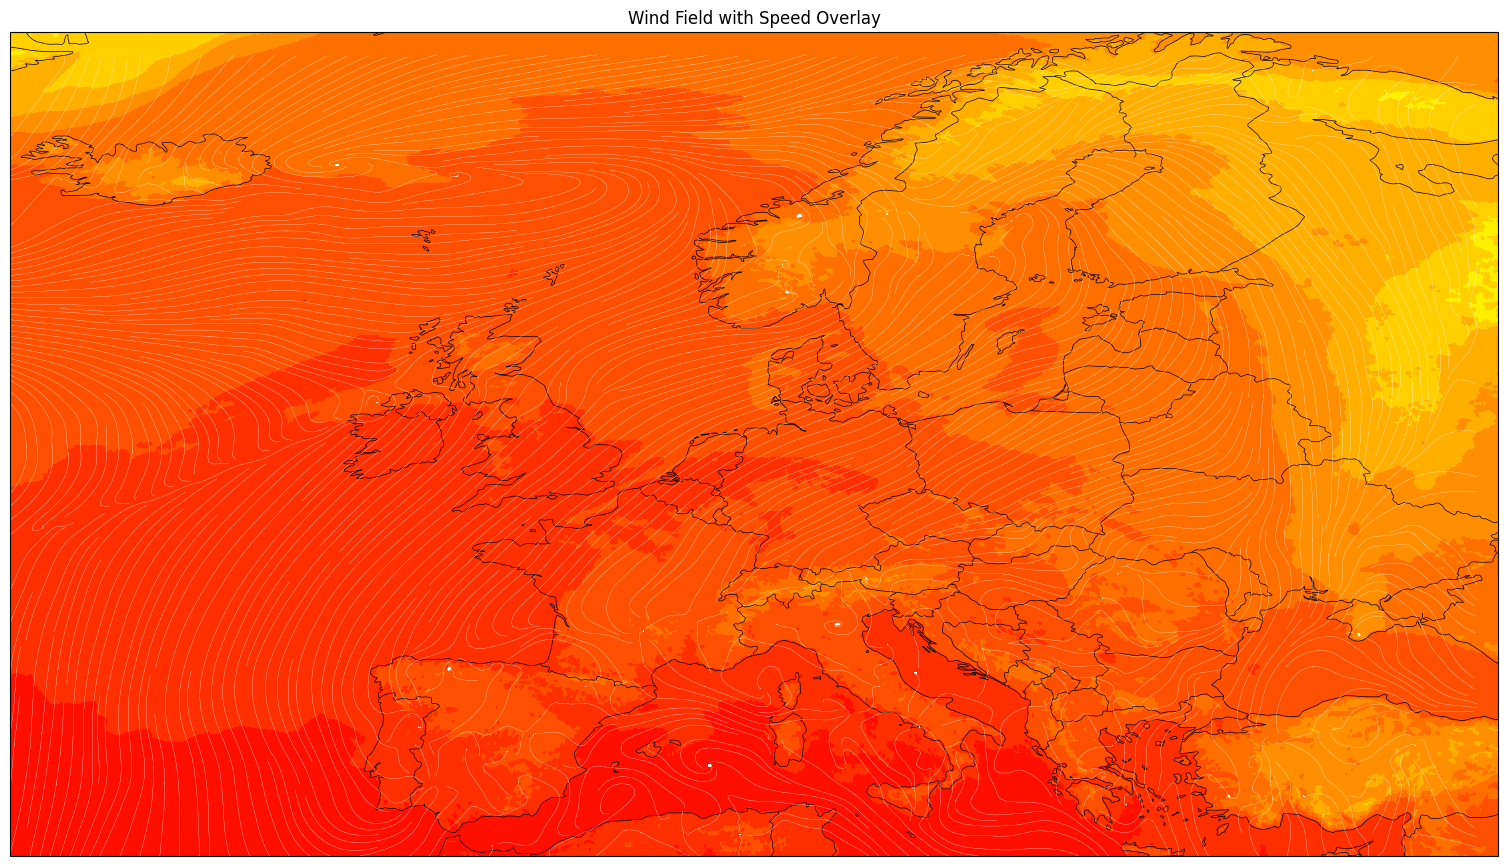

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assume your dataset is called hr_data
timestep = 1  # Select the timestep you want to plot

# Extract wind components at the given timestep
u10 = hr_data['u10'].isel(time=timestep)
v10 = hr_data['v10'].isel(time=timestep)
lon = hr_data['longitude']
lat = hr_data['latitude']
t2m = hr_data['t2m'].isel(time=timestep)  # Extract temperature at 2m

# Calculate wind speed
wind_speed = np.sqrt(u10**2 + v10**2)

# Subsample for visualization (adjust values for clarity)
step = 20  # Adjust step size for better readability
lon_sub = lon[::step]
lat_sub = lat[::step]
u10_sub = u10[::step, ::step]
v10_sub = v10[::step, ::step]
wind_speed_sub = wind_speed[::step, ::step]

# Create a quiver plot with wind speed overlay
fig = plt.figure(figsize=(19.2, 10.8), dpi=100)  # Keep consistent 1080p resolution
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)

heatmap = ax.contourf(hr_data['longitude'], hr_data['latitude'], t2m,
                        cmap="autumn_r", transform=ccrs.PlateCarree())

stream = plt.streamplot(lon_sub, lat_sub, u10_sub, v10_sub, arrowstyle="-", color="white", density=5, linewidth=0.2)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wind Field with Speed Overlay')
plt.show()

In [11]:
paths = stream.lines.get_paths()
segments = stream.lines.get_segments()

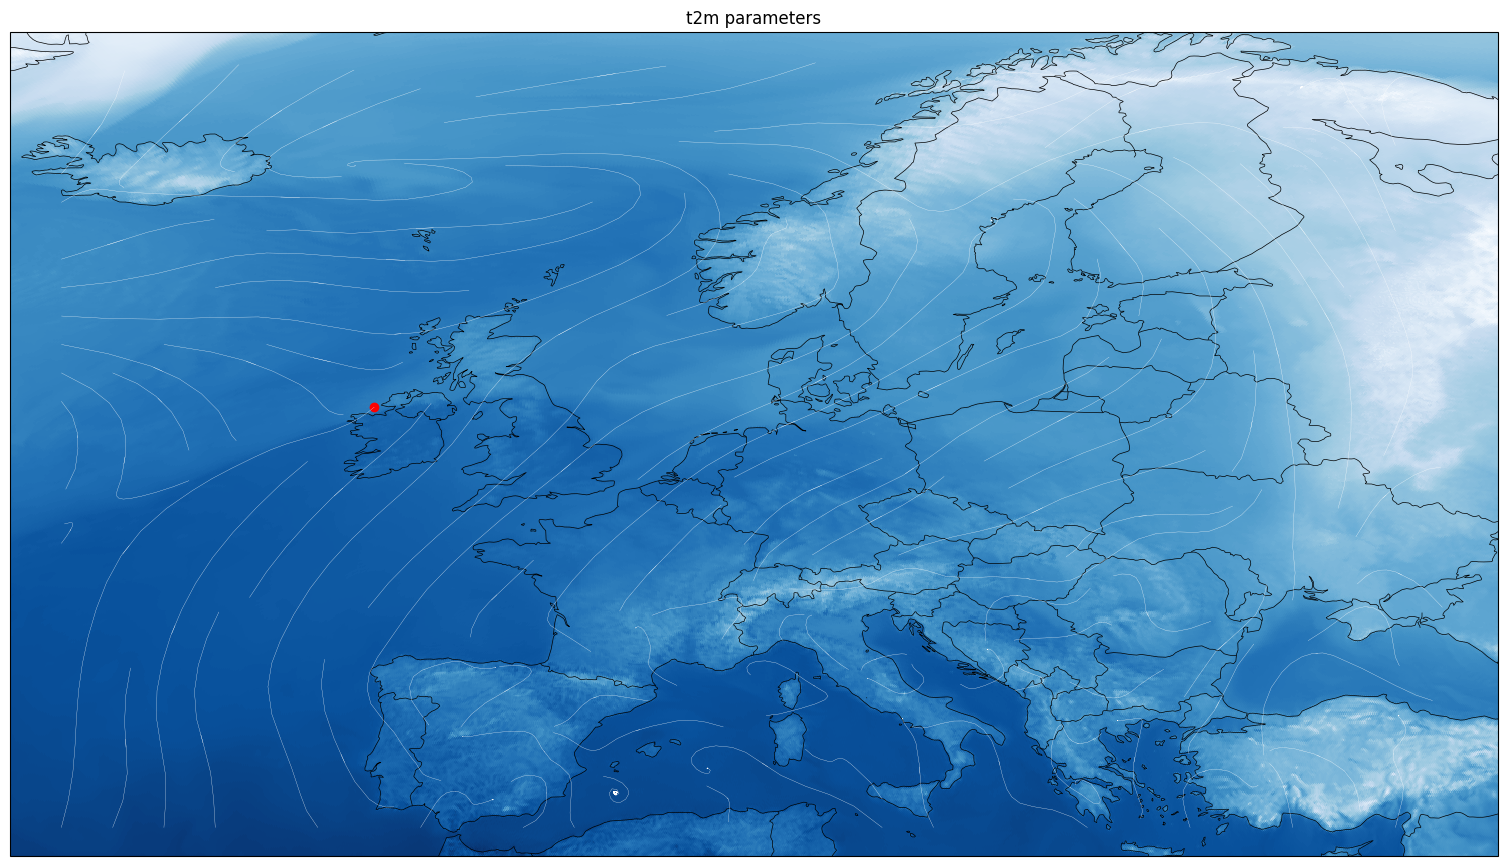

In [12]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)

heatmap = ax.pcolormesh(hr_data['longitude'], hr_data['latitude'], t2m,
                        cmap="Blues", transform=ccrs.PlateCarree())
# Initialize the streamplot
stream = ax.streamplot(lon_sub, lat_sub, u10_sub, v10_sub, arrowstyle="-", color="white", density=1, linewidth=0.2)
# Get the segments of the streamlines
segments = stream.lines.get_segments()
ax.scatter(segments[0][-1][0],segments[0][-1][1], color="red")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('t2m parameters')
plt.show()

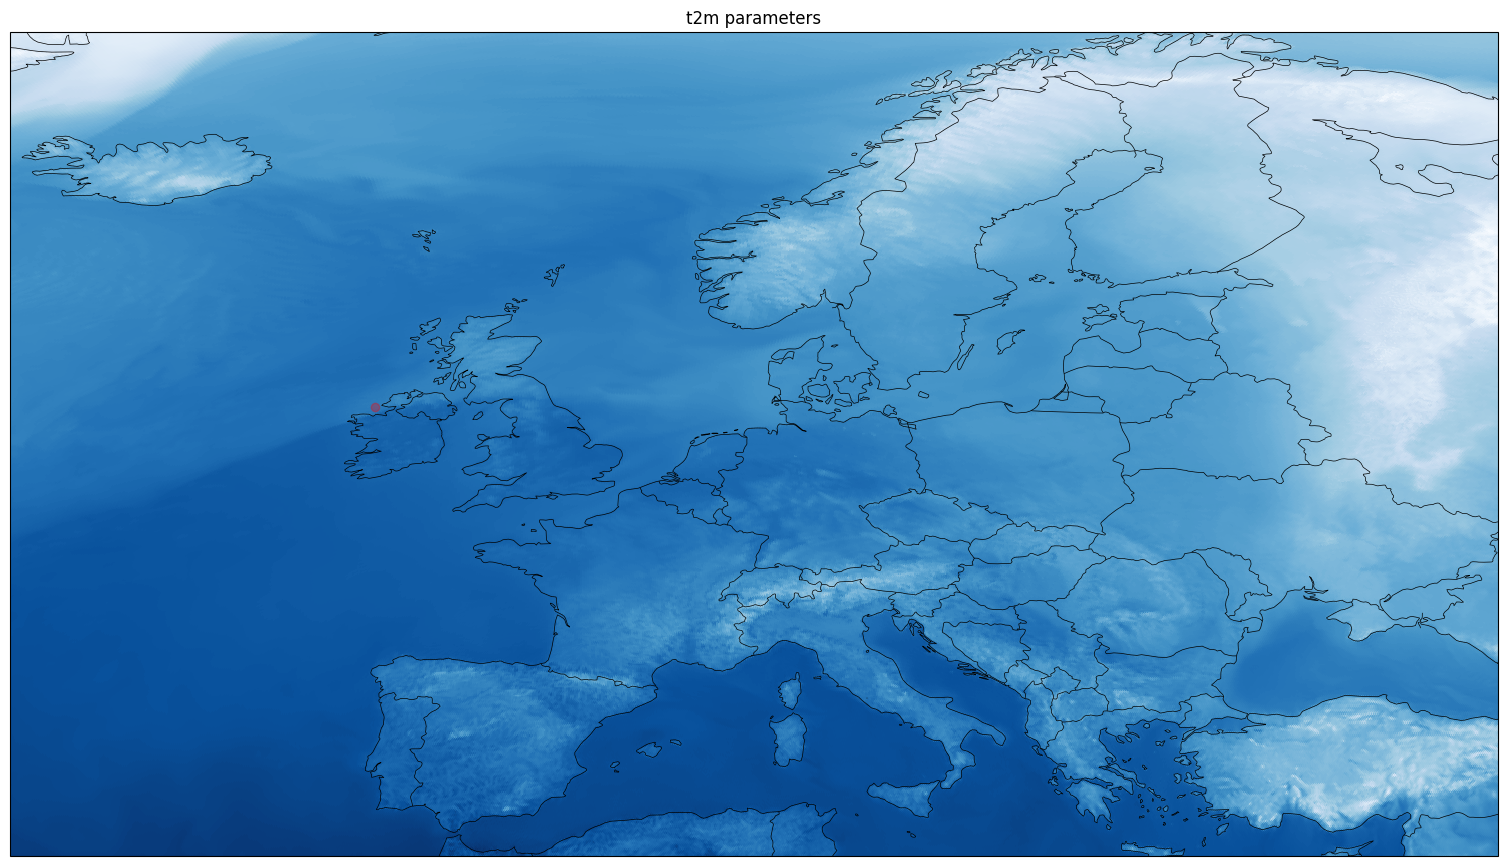

In [13]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
# Set the bounding box (lon_min, lon_max, lat_min, lat_max)
bbox = [longitude_range[0], longitude_range[1], latitude_range[0], latitude_range[1]]
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)
# Get the segments of the streamlines
segments = stream.lines.get_segments()
heatmap = ax.pcolormesh(hr_data['longitude'], hr_data['latitude'], t2m,
                        cmap="Blues", transform=ccrs.PlateCarree())
ax.scatter(segments[0][-2][0],segments[0][-2][1], color="red", alpha=0.3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('t2m parameters')
plt.show()

In [14]:
seg = segments[0]
cumulative_points = []

# Iterate over the segment
for s in range(len(seg)):
    tmp_seg = seg[:s]
    # print(tmp_seg.shape)
    x = tmp_seg[:,0]
    y = tmp_seg[:,1]

In [ ]:

func=lambda x:['x' for i in range(segments)]


###
0
###
###
1
###
###
2
###
###
3
###
###
4
###
###
5
###
###
6
###
###
7
###
###
8
###
###
9
###
###
10
###
###
11
###
###
12
###
###
13
###


KeyboardInterrupt: 

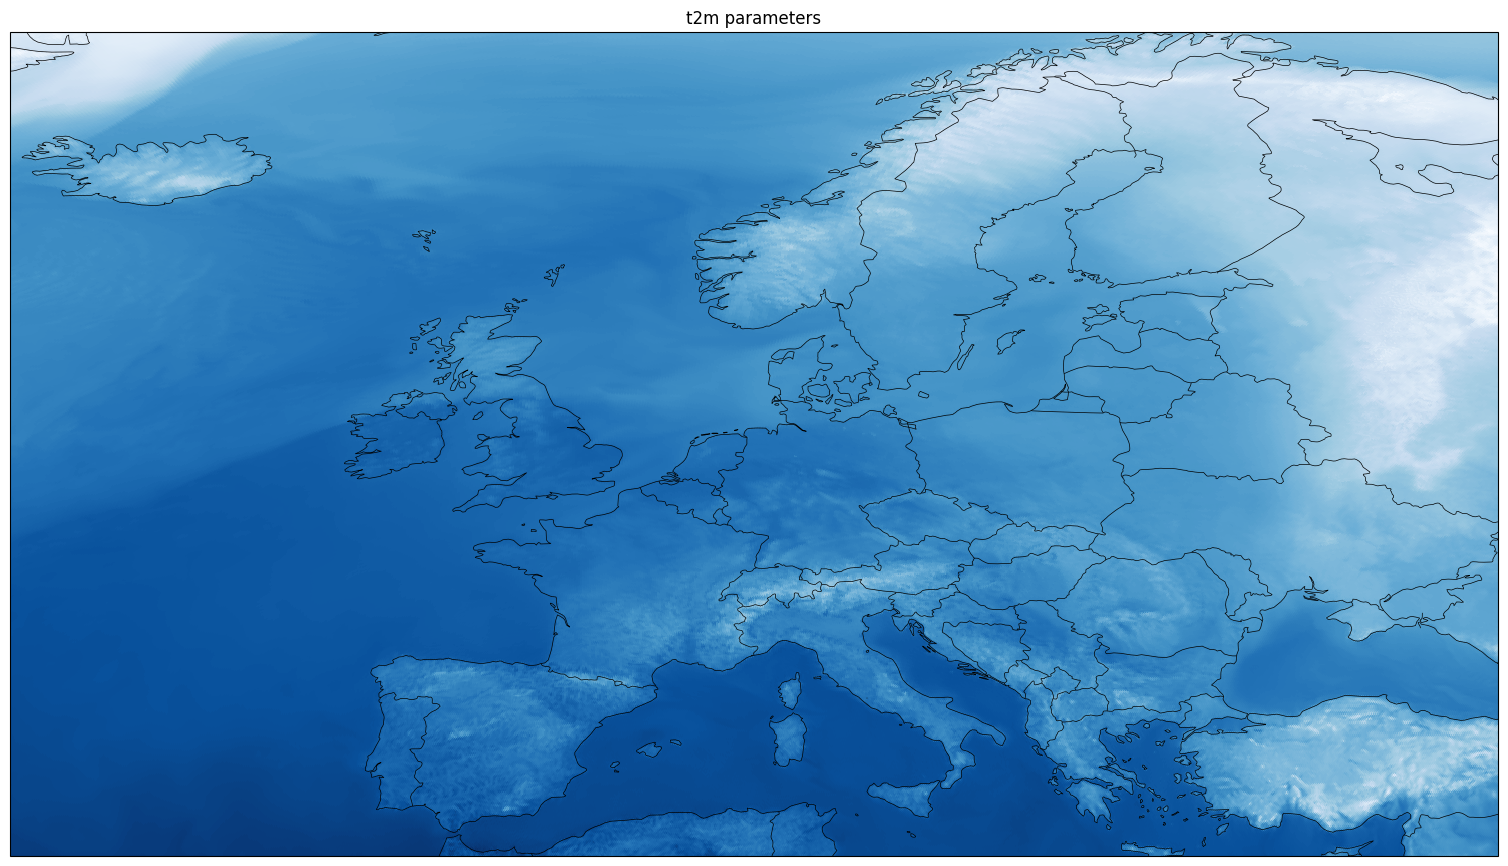

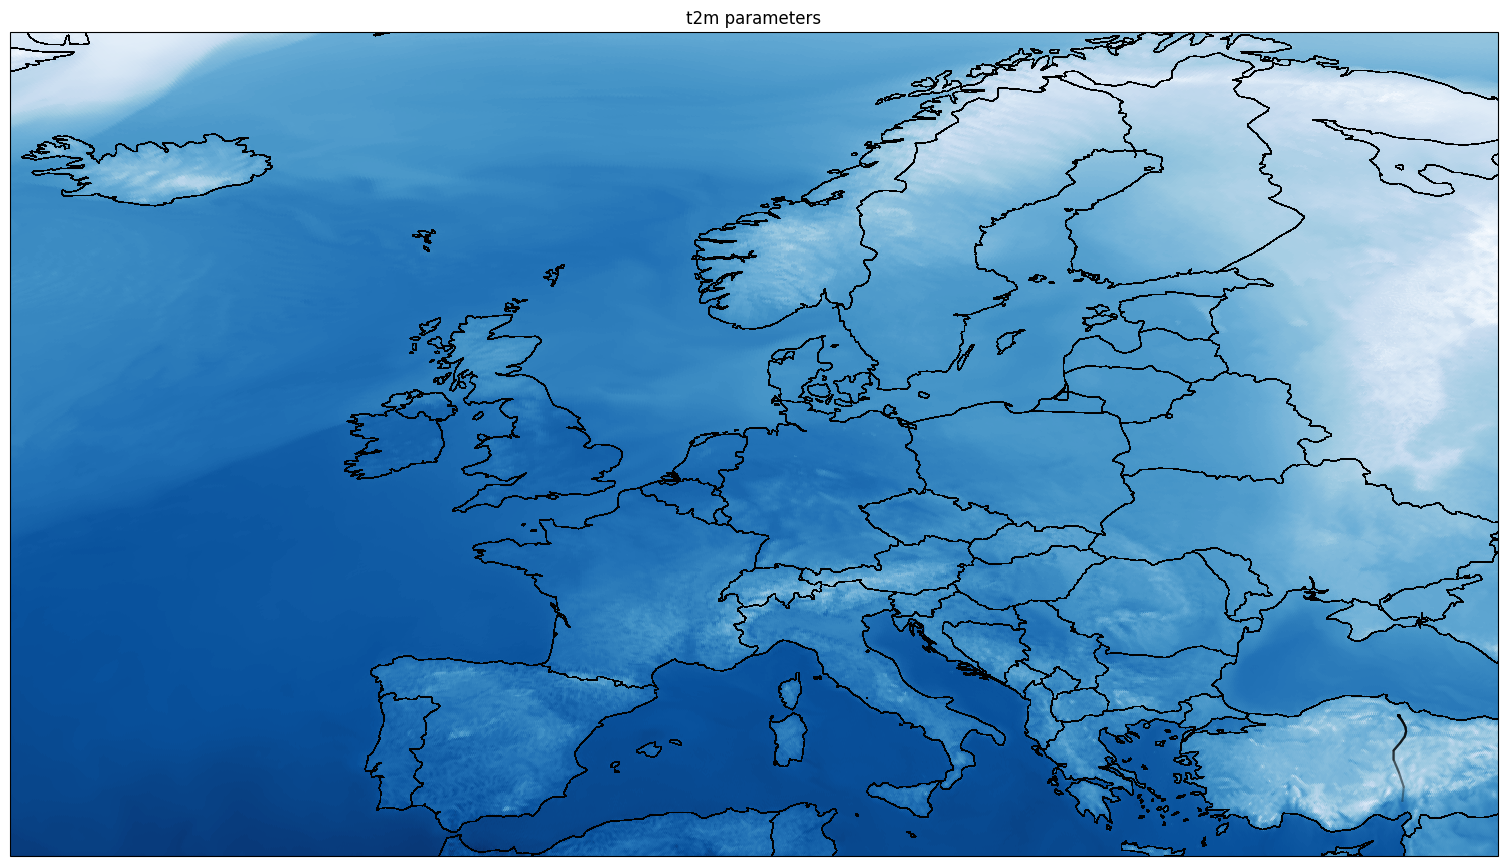

In [ ]:
# Subsample for visualization (adjust values for clarity)
step = 20  # Adjust step size for better readability
lon_sub = lon[::step]
lat_sub = lat[::step]
u10_sub = u10[::step, ::step]
v10_sub = v10[::step, ::step]
wind_speed_sub = wind_speed[::step, ::step]

# Initialize the streamplot
 # Set the bounding box (lon_min, lon_max, lat_min, lat_max)
bbox = [longitude_range[0], longitude_range[1], latitude_range[0], latitude_range[1]]

fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(bbox, crs=ccrs.PlateCarree())
heatmap = ax.pcolormesh(hr_data['longitude'], hr_data['latitude'], t2m,
                                cmap="Blues", transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('t2m parameters')
# Get the segments of the streamlines
segments = stream.lines.get_segments()

frame_count = 0
seg = segments[0]



# Iterate over the segment
for s in range(len(seg)):
    fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent(bbox, crs=ccrs.PlateCarree())
    heatmap = ax.pcolormesh(hr_data['longitude'], hr_data['latitude'], t2m,
                                    cmap="Blues", transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('t2m parameters')
    tmp_seg = seg[:s]
    x = tmp_seg[:,0]
    y = tmp_seg[:,1]
    # Plot all accumulated points
    ax.plot(x, y, color="Black", alpha=0.2, transform=ccrs.PlateCarree())
    # Save the figure with a formatted filename
    plt.savefig(f"/home/ubuntu/project/destine-super-resolution/data/frame/{frame_count}.png")
    frame_count += 1
    plt.close()

In [ ]:
# Subsample for visualization (adjust values for clarity)
step = 20  # Adjust step size for better readability
lon_sub = lon[::step]
lat_sub = lat[::step]
u10_sub = u10[::step, ::step]
v10_sub = v10[::step, ::step]
wind_speed_sub = wind_speed[::step, ::step]

# Initialize the streamplot
 # Set the bounding box (lon_min, lon_max, lat_min, lat_max)
bbox = [longitude_range[0], longitude_range[1], latitude_range[0], latitude_range[1]]

fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(bbox, crs=ccrs.PlateCarree())
heatmap = ax.pcolormesh(hr_data['longitude'], hr_data['latitude'], t2m,
                                cmap="Blues", transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('t2m parameters')
# Get the segments of the streamlines
segments = stream.lines.get_segments()

frame_count = 0
seg = segments[0]



# Iterate over the segment
for s in range(len(seg)):
    fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent(bbox, crs=ccrs.PlateCarree())
    heatmap = ax.pcolormesh(hr_data['longitude'], hr_data['latitude'], t2m,
                                    cmap="Blues", transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('t2m parameters')
    tmp_seg = seg[:s]
    x = tmp_seg[:,0]
    y = tmp_seg[:,1]
    # Plot all accumulated points
    ax.plot(x, y, color="Black", alpha=0.2, transform=ccrs.PlateCarree())
    # Save the figure with a formatted filename
    plt.savefig(f"/home/ubuntu/project/destine-super-resolution/data/frame/{frame_count}.png")
    frame_count += 1
    plt.close()